# Tarea 3
## Giovanni Gamaliel López Padilla

### Dataset

La siguiente clase concentra las metodologias para organizar los indices de los pixeles de la imagen y genera el dataloader que se le dara al modelo SIREN

In [1]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import Tensor
from numpy import (
    meshgrid,
    arange,
    stack,
    array,
)


class Dataset:
    """
    -
    """

    def __init__(self,
                 params: dict) -> None:
        self.image = params["image"]
        self.to_tensor = ToTensor()
        self.image_tensor = None
        self.batch_size = None
        self.data = None
        self._get_dataset()

    def _get_dataset(self) -> Tensor:
        x = self.create_columns()
        y = self._get_target()
        self.data = DataLoader(
            dataset=[*zip(x, y)],
            batch_size=self.batch_size,
            shuffle=True
        )

    def create_columns(self) -> Tensor:
        rows, cols = self.image.size
        self.batch_size = rows*(cols//10)
        i, j = meshgrid(
            arange(rows),
            arange(cols),
        )
        i = self._normalization(
            i,
            rows
        )
        j = self._normalization(
            j, cols
        )
        x = stack([i, j])
        x = x.T
        x = self.to_tensor(x)
        x = x[0]
        return x

    def _get_target(self) -> Tensor:
        self.image_tensor = self.to_tensor(
            self.image
        )
        y = self.image_tensor.flatten()
        y = y-0.5
        return y

    def _normalization(self,
                       matrix: array,
                       size: int) -> array:
        vector = matrix.flatten()
        vector = vector.astype("float32")
        vector = (vector/size)-0.5
        return vector

### Quadratic membrane

La clase `QuadraticMembraneFilter` contiene el modelo de optimización dada una imagen de entrada de un canal. El modelo esta basado en el modelo de observación 

$$
g(x) = f(x)+\eta(x)
$$

Donde $f$ es la imagen verdadera y $g$ es la imagen observada con $\eta\sim \mathcal{N}(0,\sigma^2)$. La funcion objetivo del modelo es 

$$
L(f) = ||g-f||^2 + \lambda ||\nabla f||^2
$$

donde el gradiente puede calcularse como 


$$
f_x(x,y) = f(x+1,y)-f(x,y)\\
f_y(x,y) = f(x,y+1)-f(x,y)\\
||\nabla f||^2 = f_x^2 + f_y^2
$$

In [2]:
from torchvision.transforms import (
    ToPILImage,
    ToTensor,
)
from torch.nn.functional import pad
from torch.optim import Adam
from PIL.Image import Image
from torch import Tensor
from torch import mean
from torch import cuda
from torch.nn import (
    Parameter,
    MSELoss,
)


class QuadraticMembraneFilter:
    """
    -
    """

    def __init__(self,
                 image: Image,
                 alpha: int) -> None:
        self.to_image = ToPILImage()
        self.to_tensor = ToTensor()
        self.optimizer = None
        self.loss = MSELoss()
        self.output = None
        self.device = None
        self.image = None
        self.alpha = alpha
        self._get_device()
        self._get_tensors(image)
        self._get_optimizer()

    def _get_tensors(self,
                     image: Image) -> None:
        """
        -
        """
        self.image = self.to_tensor(image)
        self.image = self._to_device(self.image)
        self.output = self.image.clone()
        self.output = self._to_device(self.output)
        self.output = self.output.requires_grad_(True)
        self.output = Parameter(self.output)

    def _get_device(self) -> None:
        """
        -
        """
        if cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'

    def _to_device(self,
                   tensor: Tensor) -> None:
        """
        -
        """
        tensor = tensor.to(self.device)
        return tensor

    def _get_optimizer(self) -> None:
        """
        -
        """
        self.optimizer = Adam([self.output])

    def _L2_gradient(self,
                     f: Tensor) -> Tensor:
        '''
        Calcula el promedio de la magnitud del gradiente espacial
        de la imagen multicanal f  (c,h,w)
        '''
        # gradiente
        fx, fy = self._gradient(f)
        # promedio de la magnitud del gradiente
        l2 = mean(fx**2+fy**2)
        return l2

    def _gradient(self,
                  f: Tensor) -> tuple:
        '''
        Entrada
        f:      (c,h,w), float32 or float64
        Resultados
        fx, fy: (c,h,w)
        '''
        # corrimientos
        # pad last dim by (0, 1)
        f_10 = pad(f, (0, 1, 0, 0))
        f_10 = f_10[:, :, 1:]
        # pad 2nd to last dim by (0, 1)
        f_01 = pad(f, (0, 0, 0, 1))
        f_01 = f_01[:, 1:, :]
        # primeras diferencias adelantadas
        fx = f_10 - f
        fy = f_01 - f
        # derivadas en la frontera
        # fx will have zeros in the last column
        fx[:, :, -1] = 0
        # fy will have zeros in the last row
        fy[:, -1, :] = 0

        return fx, fy

    def run(self,
            epochs: int) -> tuple:
        """
        -
        """
        self._fit(epochs)
        output = self.to_image(self.output)
        return output

    def _fit(self,
             epochs: int) -> None:
        """
        -
        """
        for _ in range(epochs):
            # Inicializa gradiente
            self.optimizer.zero_grad()
            # Término de datos
            loss_d = self.loss(
                self.output,
                self.image
            )
            # Término de regularización
            loss_r = self._L2_gradient(self.output)
            # Costo total
            loss = loss_d + self.alpha * loss_r
            # Retropropagación (gradiente)
            loss.backward()
            # Actualiza los parametros del modelo
            self.optimizer.step()

### Robust membrane

La clase `RobustMembraneFilter` contiene el modelo de optimización dada una imagen de entrada de un canal. El modelo esta basado en el modelo de observación 

$$
g(x) = f(x)+\eta(x)
$$

Donde $f$ es la imagen verdadera y $g$ es la imagen observada con $\eta\sim \mathcal{N}(0,\sigma^2)$. La funcion objetivo del modelo es 

$$
L(f) = ||g-f||^2 + \lambda ||\nabla f||_1
$$

donde el gradiente puede calcularse como 


$$
f_x(x,y) = f(x+1,y)-f(x,y)\\
f_y(x,y) = f(x,y+1)-f(x,y)\\
||\nabla f||_1 = ||f_x||_1 + ||f_y||_1
$$

In [3]:
from PIL.Image import Image
from torch import Tensor
from torch import (
    mean,
    abs,
)


class RobustMembraneFilter(QuadraticMembraneFilter):
    """
    -
    """

    def __init__(self,
                 image: Image,
                 alpha: int) -> None:
        super().__init__(
            image,
            alpha,
        )

    def _L1_gradient(self,
                     f: Tensor) -> Tensor:
        '''
        Calcula el promedio de la magnitud del gradiente espacial
        de la imagen multicanal f  (c,h,w)
        '''
        # gradiente
        fx, fy = self._gradient(f)
        # promedio de la magnitud del gradiente
        l1 = mean(abs(fx) + abs(fy))
        return l1

    def _fit(self,
             epochs: int) -> None:
        """
        -
        """
        for _ in range(epochs):
            # Inicializa gradiente
            self.optimizer.zero_grad()
            # Término de datos
            loss_d = self.loss(
                self.output,
                self.image
            )
            # Término de regularización
            loss_r = self._L1_gradient(self.output)
            # Costo total
            loss = loss_d + self.alpha * loss_r
            # Retropropagación (gradiente)
            loss.backward()
            # Actualiza los parametros del modelo
            self.optimizer.step()

### Representación implícita

Asumimos que existe una función $f$ que realiza el mapeo

$$
f: x \rightarrow y
$$

donde $x$ es la variable independiente y $y$ la dependiente. Para un par de valores $(x,y)$ tenemos un valor z, el cual representa el valor del piexel en la posición dada. Crearemos un modelo con parametros $\Phi_\theta$, la cual aproxima a la función verdadera. Para optimizar los parametros se usara la función objetivo

$$
L(\theta;x,y) = \sum ||y_i-\hat{y}_i(\theta)||
$$

#### Capa SIREN

Esta capa es denominada SIREN y toma su nombre de Periodic Activation Implicit Neural Representations (Sitzmann et al., 2020). Esta capa corresponde a una capa densa pero con activación senoidal:

$$
\text{siren}(x;\omega,W,b) = sin(\omega(Wx+b))
$$

Los parametros de la primer capa se definen como

$$
W_1,b_1\sim U\left(\left[-\frac{1}{n} , \frac{1}{n}\right] \right)
$$

y para las siguientes se inicializan como

$$
W_i,b_i\sim U\left(\left[-\frac{1}{30}\sqrt{\frac{6}{n}}, \frac{1}{30}\sqrt{\frac{6}{n}}\right] \right)
$$

In [4]:
from torch.optim import Adam
from torch.nn import (
    Sequential,
    MSELoss,
    Module,
    Linear
)
from numpy import (
    array,
    sqrt,
)
from torch import (
    no_grad,
    Tensor,
    cuda,
    save,
    sin,
)


class SineLayer(Module):
    """
    -
    """

    def __init__(self,
                 in_features: int,
                 out_features: int,
                 bias: bool = True,
                 is_first: bool = False,
                 is_last: bool = False,
                 omega_0: int = 30) -> None:
        '''
        Implementa
        sin ( omega ( W x + b) )

        in_features   : (int) dimensión de entrada
        out_features  : (int) número de neuronas (dimensión de salida)
        bias          : -
        is_fisrt      : (boolean) se escala distinto la inicialización de la
        primera capa oculta y las restantes
        is_last       : (boolean) sn funcion de activacio en la capa de salida
        '''

        super().__init__()

        self.omega_0 = omega_0
        self.is_first = is_first
        self.is_last = is_last
        self.in_features = in_features
        self.linear = Linear(
            in_features,
            out_features,
            bias=bias
        )
        self.init_weights()

    def forward(self, x) -> Tensor:
        '''
        y = Phi(omega0 W (x+b) )
        '''
        out = self.linear(x)
        out = self.omega_0 * out
        out = sin(out)
        return out

    def forward_with_intermediate(self, x):
        '''
         z =  omega0  (W x + b)
         y =  sin(z)
         (y,z)
        '''
        # For visualization of activation distributions
        out = self.linear(x)
        out = self.omega_0*x
        out = sin(out), out if not self.last else out, out
        return out

    def init_weights(self):
        '''
        Inicialización escalada para considerar a la activación periodica
        Pretende mantener la respuesta de cada neurona dentro de una misma
        rama y evitar saltos entre ramas al entrenar los pesos
        '''
        with no_grad():
            if self.is_first:
                self.linear.weight.uniform_(
                    -sqrt(1 / self.in_features),
                    sqrt(1 / self.in_features)
                )
            else:
                self.linear.weight.uniform_(
                    -sqrt(6 / self.in_features) / self.omega_0,
                    sqrt(6 / self.in_features) / self.omega_0
                )


class SIRENnet(Module):
    """
    -
    """

    def __init__(self,
                 input_dim: int,
                 hidden_dims: list,
                 output_dim: int = 1) -> None:
        super().__init__()
        # Modelo inicialmente vacio
        self.net = list()
        # Se agragan capas Seno ocultas
        is_first = True
        for i in range(len(hidden_dims)):
            is_last = False if i < len(hidden_dims)-1 else True
            self.net.append(
                SineLayer(
                    in_features=input_dim,
                    out_features=hidden_dims[i],
                    is_first=is_first,
                    is_last=is_last
                )
            )
            input_dim = hidden_dims[i]
            is_first = False
        self.net = Sequential(*self.net)

    def forward(self, x):
        out = self.net(x)
        return out

    def name(self):
        return "MLP"


class SIRENModel:
    def __init__(self,
                 params: dict) -> None:
        self.dataset = Dataset(params)
        self.model = SIRENnet(
            **params["SIREN"]
        )
        self.optimizer = None
        self.history = None
        self.device = None
        self.loss = None
        self._get_device()
        self._build()
        self.model = self._to_device(
            self.model
        )

    def _build(self) -> None:
        self.optimizer = Adam(self.model.parameters())
        self.loss = MSELoss()

    def train(self) -> None:
        epochs = 100
        history = list()
        for epoch in range(epochs):
            loss_epoch = 0
            for i, (x, y) in enumerate(self.dataset.data):
                x = self._to_device(x)
                y = self._to_device(y)
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                y_pred = y_pred[:, 0]
                loss = self.loss(
                    y_pred,
                    y
                )
                loss.backward()
                self.optimizer.step()
                loss_epoch += loss.data
            history.append(loss_epoch/i)
            print('Epoch: {:03}/{}  Loss: {:.6f}'.format(
                epoch,
                epochs,
                history[-1])
            )
        self.history = history

    def test(self) -> None:
        rows, cols = self.dataset.image.size
        x = self.dataset.create_columns()
        x = self._to_device(x)
        y = self.model(x)
        y = self._to_cpu(y)
        y = y.reshape(rows, cols)
        return y

    def _to_cpu(self,
                tensor: Tensor) -> array:
        vector = tensor.detach().cpu().numpy()
        return vector

    def _to_device(self,
                   tensor: Tensor) -> Tensor:
        return tensor.to(self.device)

    def _get_device(self) -> None:
        if cuda.is_available():
            self.device = "cuda"
        else:
            self.device = 'cpu'

Epoch: 000/100  Loss: 0.523421
Epoch: 001/100  Loss: 0.513581
Epoch: 002/100  Loss: 0.511454
Epoch: 003/100  Loss: 0.494197
Epoch: 004/100  Loss: 0.473847
Epoch: 005/100  Loss: 0.454692
Epoch: 006/100  Loss: 0.444759
Epoch: 007/100  Loss: 0.441038
Epoch: 008/100  Loss: 0.435641
Epoch: 009/100  Loss: 0.433945
Epoch: 010/100  Loss: 0.425471
Epoch: 011/100  Loss: 0.393416
Epoch: 012/100  Loss: 0.198830
Epoch: 013/100  Loss: 0.070478
Epoch: 014/100  Loss: 0.042991
Epoch: 015/100  Loss: 0.032658
Epoch: 016/100  Loss: 0.025032
Epoch: 017/100  Loss: 0.019549
Epoch: 018/100  Loss: 0.016207
Epoch: 019/100  Loss: 0.013683
Epoch: 020/100  Loss: 0.012043
Epoch: 021/100  Loss: 0.010495
Epoch: 022/100  Loss: 0.009283
Epoch: 023/100  Loss: 0.008357
Epoch: 024/100  Loss: 0.007520
Epoch: 025/100  Loss: 0.006859
Epoch: 026/100  Loss: 0.006392
Epoch: 027/100  Loss: 0.005944
Epoch: 028/100  Loss: 0.005584
Epoch: 029/100  Loss: 0.005251
Epoch: 030/100  Loss: 0.005037
Epoch: 031/100  Loss: 0.004821
Epoch: 0

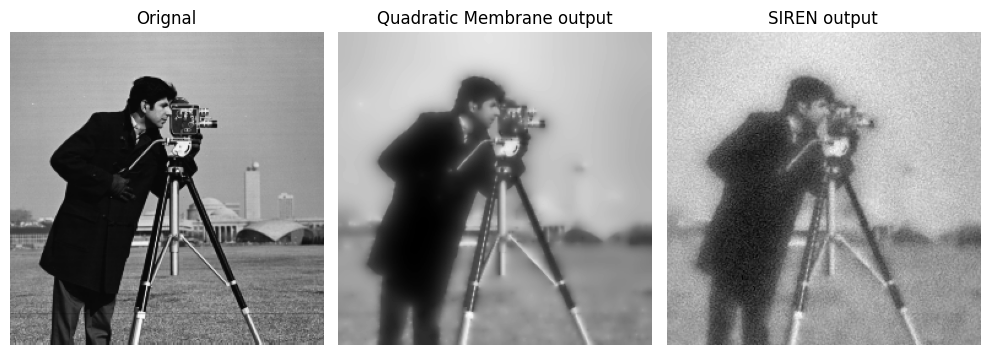

In [5]:
import matplotlib.pyplot as plt
from numpy import array
from PIL import Image


def plot(image: array,
         title: str,
         ax: plt.axes) -> None:
    ax.imshow(image,
              cmap="gray")
    ax.axis("off")
    ax.set_title(title)


img = Image.open('Cameraman.tif')
params = {
    "SIREN": {
        "input_dim": (2),
        "hidden_dims": [
            128,
            128,
            128,
            128,
            1
        ],
        "output_dim": 1,
    },
    "alpha": 100,
}
membrane_filter = QuadraticMembraneFilter(
    img,
    params["alpha"],
)
output = membrane_filter.run(300)
params["image"] = output
schedule = SIRENModel(
    params
)
schedule.train()
y = schedule.test()
fig, (ax1, ax2, ax3) = plt.subplots(
    1,
    3,
    figsize=(10, 5)
)
plot(
    img,
    "Orignal",
    ax1
)
plot(
    output,
    "Quadratic Membrane output",
    ax2
)
plot(
    y,
    "SIREN output",
    ax3
)
plt.tight_layout()
plt.show()

Los resultados obtenidos por el ensamble Quadratic-SIREN obtiene resultados coherentes al funcionamiento de SIREN. Las imagenes generadas por SIREN contienen una granuladidad a comparación de la imagen real pero manteniendo los detalles de la misma.

Epoch: 000/100  Loss: 0.522848
Epoch: 001/100  Loss: 0.415393
Epoch: 002/100  Loss: 0.377392
Epoch: 003/100  Loss: 0.296508
Epoch: 004/100  Loss: 0.166641
Epoch: 005/100  Loss: 0.079806
Epoch: 006/100  Loss: 0.043620
Epoch: 007/100  Loss: 0.027647
Epoch: 008/100  Loss: 0.019746
Epoch: 009/100  Loss: 0.016273
Epoch: 010/100  Loss: 0.013895
Epoch: 011/100  Loss: 0.012172
Epoch: 012/100  Loss: 0.009281
Epoch: 013/100  Loss: 0.006945
Epoch: 014/100  Loss: 0.005688
Epoch: 015/100  Loss: 0.005715
Epoch: 016/100  Loss: 0.005908
Epoch: 017/100  Loss: 0.005654
Epoch: 018/100  Loss: 0.004950
Epoch: 019/100  Loss: 0.004720
Epoch: 020/100  Loss: 0.004162
Epoch: 021/100  Loss: 0.002858
Epoch: 022/100  Loss: 0.003109
Epoch: 023/100  Loss: 0.002561
Epoch: 024/100  Loss: 0.002720
Epoch: 025/100  Loss: 0.002478
Epoch: 026/100  Loss: 0.004481
Epoch: 027/100  Loss: 0.002901
Epoch: 028/100  Loss: 0.002247
Epoch: 029/100  Loss: 0.002079
Epoch: 030/100  Loss: 0.001976
Epoch: 031/100  Loss: 0.002638
Epoch: 0

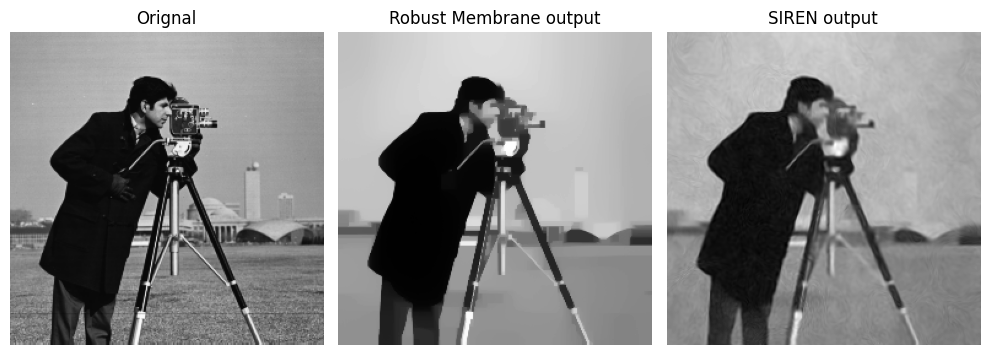

In [6]:
import matplotlib.pyplot as plt
from numpy import array
from PIL import Image


def plot(image: array,
         title: str,
         ax: plt.axes) -> None:
    ax.imshow(image,
              cmap="gray")
    ax.axis("off")
    ax.set_title(title)


img = Image.open('Cameraman.tif')
params = {
    "SIREN": {
        "input_dim": (2),
        "hidden_dims": [
            128,
            128,
            128,
            128,
            1
        ],
        "output_dim": 1,
    },
    "alpha": 100,
}
membrane_filter = RobustMembraneFilter(
    img,
    params["alpha"],
)
output = membrane_filter.run(300)
params["image"] = output
schedule = SIRENModel(
    params
)
schedule.train()
y = schedule.test()
fig, (ax1, ax2, ax3) = plt.subplots(
    1,
    3,
    figsize=(10, 5)
)
plot(
    img,
    "Orignal",
    ax1
)
plot(
    output,
    "Robust Membrane output",
    ax2
)
plot(
    y,
    "SIREN output",
    ax3
)
plt.tight_layout()
plt.show()

De igual manera que Quadratic-SIREN, Robust-SIREN obtiene una imágen con las propiedades originales de la imagen de entrada pero con una mayor granuladidad en sus resultados. 

Se implemento la optimización en conjunto de SIREN y los filtros de membranas pero se obtenian resultados peores a los mostrados en este notebook. Estos resultados puede ser debido al tamaño del batch size (256*256). Esto para mantener el calculo del gradiente con el desplazamiento.

El aumento de las epocas de cada entrenamiento no resulta en mejores resultados.

De igual manera, estas implementaciones muestran que SIREN puede usarse para obtener una aproximación a las optimizaciones usando membranas cuadraticas y robustas.